<a href="https://colab.research.google.com/github/sharmin133/Rice-Leaf/blob/main/Resnet50%2Bgaussian%2Bprewitt_final_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras import layers, models
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.applications import ResNet50

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 45
CHANNELS=3
EPOCHS=25

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Final Thesis/Feature Extraction/Prewitt edge detection/prewitt+gaussian",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7471 files belonging to 5 classes.


In [ ]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro', '_Healthy']


117

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 45, 45, 3)
[0 2 3 3 0 1 1 4 2 0 4 2 3 0 0 1 2 4 3 2 1 4 2 3 2 1 4 0 3 1 0 2 1 2 3 3 4
 0 3 3 0 0 2 0 1 2 3 4 4 1 3 0 3 0 2 4 3 0 3 2 4 0 0 1]


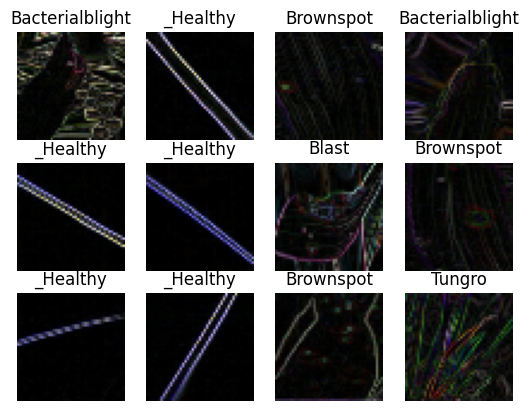

In [ ]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split +  val_split+test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

81
11
25


In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
n_classes = len(class_names)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 3

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
81/81 [==============================] - 819s 1s/step - loss: 1.3388 - accuracy: 0.5547 - val_loss: 0.5674 - val_accuracy: 0.7912
Epoch 2/25
81/81 [==============================] - 62s 769ms/step - loss: 0.7357 - accuracy: 0.7203 - val_loss: 0.3986 - val_accuracy: 0.8608
Epoch 3/25
81/81 [==============================] - 60s 746ms/step - loss: 0.5576 - accuracy: 0.7943 - val_loss: 0.3266 - val_accuracy: 0.8935
Epoch 4/25
81/81 [==============================] - 61s 746ms/step - loss: 0.4430 - accuracy: 0.8343 - val_loss: 0.2264 - val_accuracy: 0.9219
Epoch 5/25
81/81 [==============================] - 63s 773ms/step - loss: 0.3548 - accuracy: 0.8707 - val_loss: 0.1734 - val_accuracy: 0.9375
Epoch 6/25
81/81 [==============================] - 58s 716ms/step - loss: 0.3010 - accuracy: 0.8928 - val_loss: 0.1513 - val_accuracy: 0.9489
Epoch 7/25
81/81 [==============================] - 55s 684ms/step - loss: 0.2612 - accuracy: 0.9027 - val_loss: 0.1273 - val_accuracy: 0.9531
E

In [ ]:
scores = model.evaluate(test_ds)

25/25 [==============================] - 41s 607ms/step - loss: 0.0286 - accuracy: 0.9893


In [ ]:
scores

[0.02859196625649929, 0.9892609119415283]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

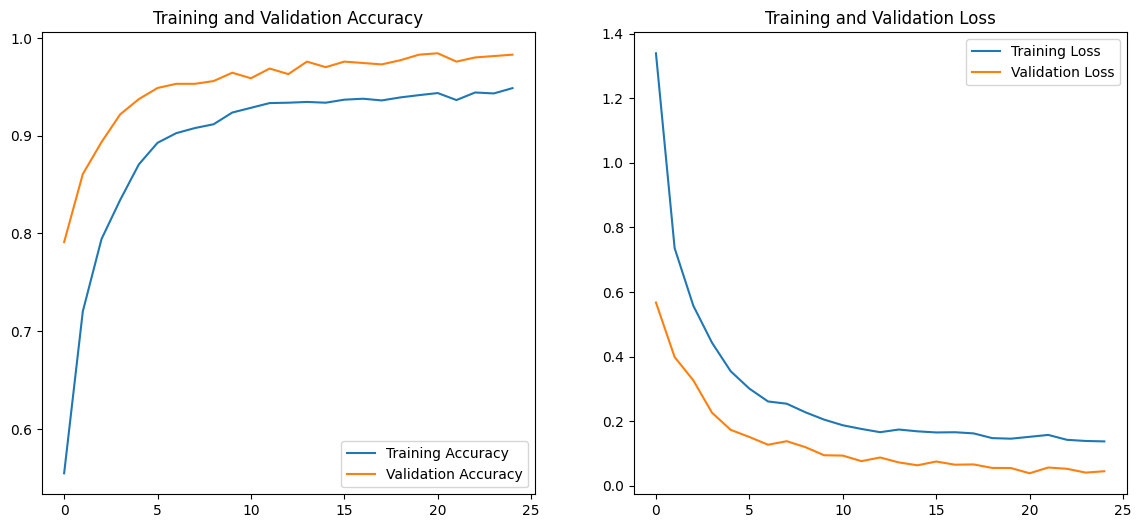

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterialblight
2/2 [==============================] - 3s 476ms/step
predicted label: Bacterialblight


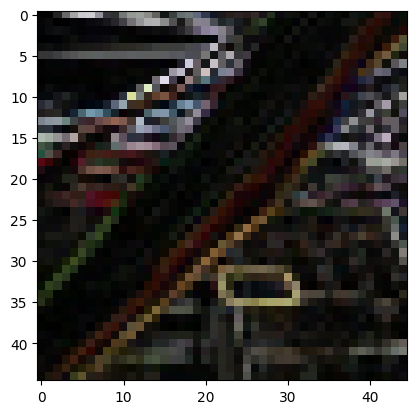

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

50/50 [==============================] - 17s 311ms/step


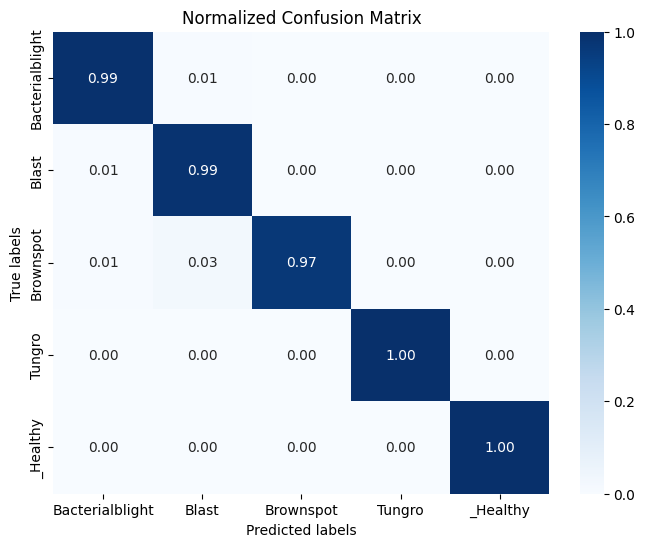

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
predicted_labels = np.argmax(model.predict(test_images), axis=-1)
cm = confusion_matrix(test_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = class_names
report = classification_report(test_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       0.99      0.99      0.99       341
          Blast       0.96      0.99      0.98       303
      Brownspot       1.00      0.97      0.98       344
         Tungro       1.00      1.00      1.00       287
       _Healthy       1.00      1.00      1.00       308

       accuracy                           0.99      1583
      macro avg       0.99      0.99      0.99      1583
   weighted avg       0.99      0.99      0.99      1583

